<a href="https://colab.research.google.com/github/jonaidsharif/Twitter-And-Reddit-Sentiment-Analysis/blob/main/Twitter_and_Reddit_Sentiment_Analysis_Practice_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Kaggle

Create directory



In [3]:
!mkdir ~/.kaggle

Copy File



In [4]:
!cp kaggle.json ~/.kaggle

Read Write permission for owner only



In [5]:
!chmod 600 ~/.kaggle/kaggle.json

Download Kaggle Dataset

In [6]:
!kaggle datasets list

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           8566        160  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                         94KB  2024-09-02 10:53:57          37060        651  1.0              
aravinii/house-price-prediction-treated-dataset              House Price Prediction Treated Dataset             295KB  2024-10-15 17:43:54           1038         22  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercis

In [7]:
! kaggle datasets download 'cosmos98/twitter-and-reddit-sentimental-analysis-dataset'

Dataset URL: https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset
License(s): CC-BY-NC-SA-4.0
  0% 0.00/10.0M [00:00<?, ?B/s]
100% 10.0M/10.0M [00:00<00:00, 177MB/s]


In [8]:
!unzip twitter-and-reddit-sentimental-analysis-dataset.zip

Archive:  twitter-and-reddit-sentimental-analysis-dataset.zip
  inflating: Reddit_Data.csv         
  inflating: Twitter_Data.csv        


importing libries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data Extraction & Cleaning

In [9]:
reddit_data = pd.read_csv('/content/Reddit_Data.csv')
twitter_data = pd.read_csv('/content/Twitter_Data.csv')

In [10]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())

    for i in punc:
        cleanedText = cleanedText.replace(i, '')

    a = [i for i in cleanedText if i.isalpha() or i == ' ']

    final_text = ' '.join(''.join(a).split())
    return final_text

Cleaning Data

In [11]:
reddit_data = reddit_data.dropna(how='any')
twitter_data = twitter_data.dropna(how='any')

In [12]:
reddit_data.rename(columns={'clean_comment':'comment'}, inplace=True)
twitter_data.rename(columns={'clean_text':'comment'}, inplace=True)

reddit_data.category = reddit_data.category.apply(lambda x: int(x))
twitter_data.category = twitter_data.category.apply(lambda x: int(x))

reddit_data.comment = reddit_data.comment.apply(cleanText)
twitter_data.comment = twitter_data.comment.apply(cleanText)

In [13]:
reddit_data.drop_duplicates(subset='comment', keep=False, inplace=True)
twitter_data.drop_duplicates(subset='comment', keep=False, inplace=True)

In [14]:
# Concat reddit data and twiter data
concat_df = pd.concat([reddit_data, twitter_data], ignore_index=True)
concat_df.drop_duplicates(subset='comment', keep=False, inplace=True)

## Data Visualization

Compare Total Comments From both Platforms

In [15]:
counts = [len(reddit_data), len(twitter_data), len(concat_df)]
labels = ['Reddit', 'Twitter', 'Total']
colors = ['#ff4500', '#1DA1F2', '#50C878']

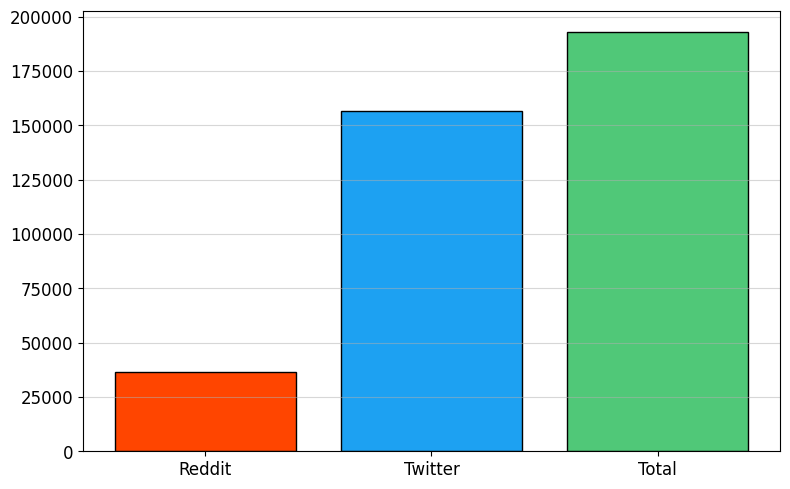

In [16]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

Count The Negative, Neutral, and Positive Comments

In [17]:
negative_count = [len(reddit_data[reddit_data.category == -1]),
                 len(twitter_data[twitter_data.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(reddit_data[reddit_data.category == 0]),
                 len(twitter_data[twitter_data.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(reddit_data[reddit_data.category == 1]),
                 len(twitter_data[twitter_data.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Reddit', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

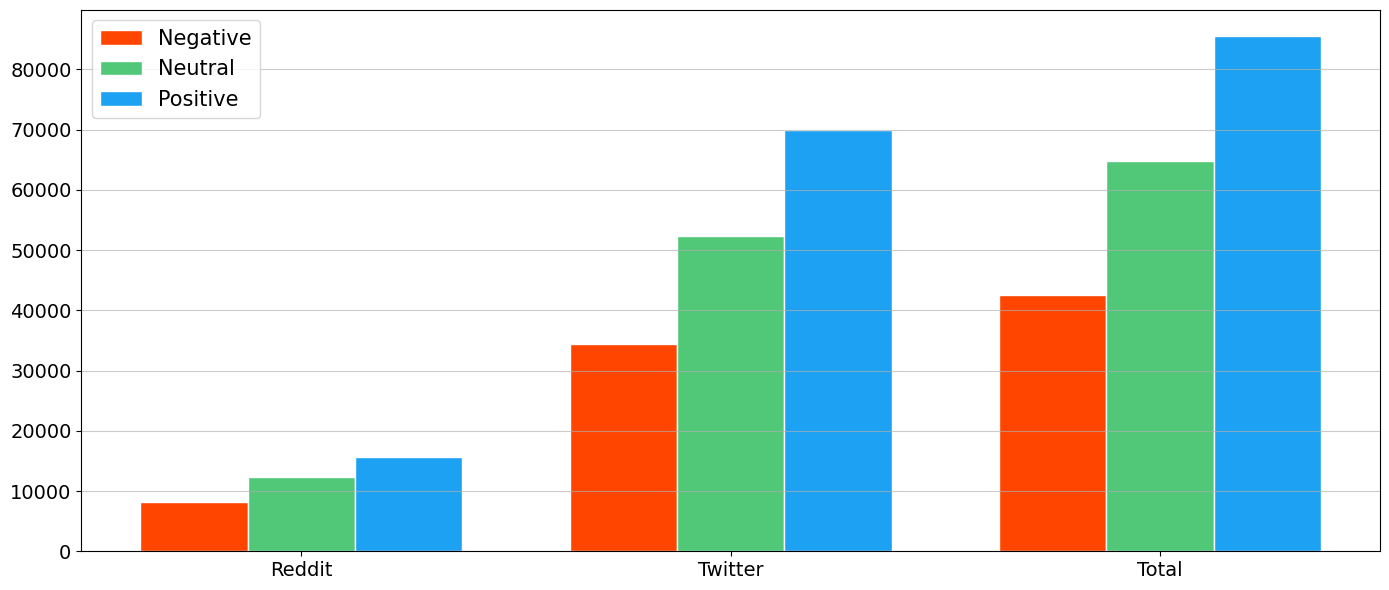

In [18]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

Count the Average Length of All the 3 Sentiments Comment

In [20]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].comment]) / len(concat_df[concat_df.category == 1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].comment]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].comment]) / len(concat_df[concat_df.category == 1]))

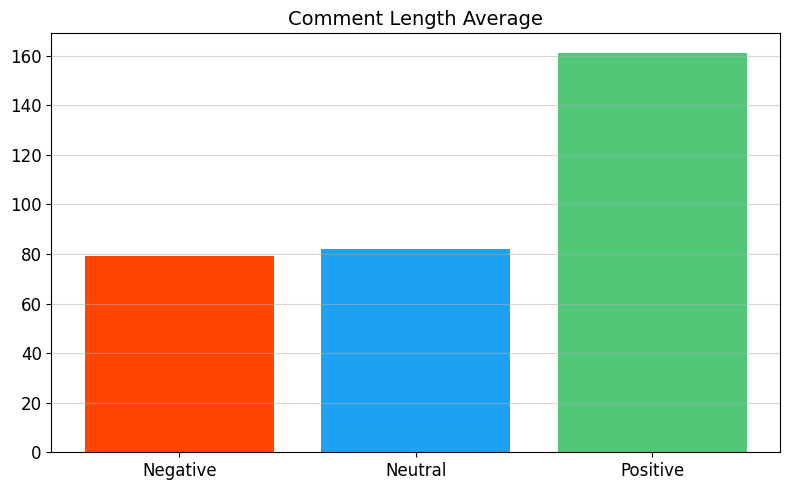

In [21]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

Create Word Clouds to See Which Words Appear Frequently

In [22]:
negative_words = ''
neutral_words = ''
positive_words = ''

stopwords = set(STOPWORDS)

for comment, category in zip(concat_df.comment, concat_df.category):
    tokens = comment.split()

    for word in tokens:
        if category == -1:
            negative_words += word + ' '
        elif category == 0:
            neutral_words += word + ' '
        else:
            positive_words += word + ' '

In [23]:
negative_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_words)

neutral_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neutral_words)

positive_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_words)

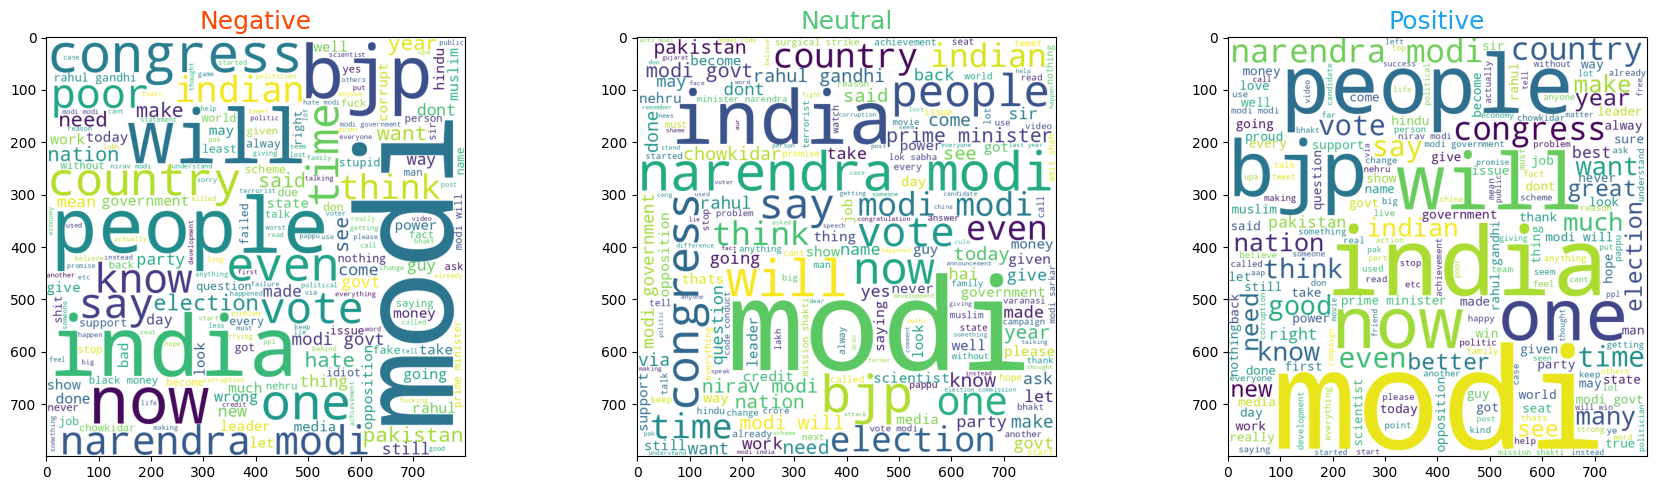

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), facecolor=None)

ax1.imshow(negative_cloud)
ax1.set_title('Negative', fontsize=18, color='#ff4500')

ax2.imshow(neutral_cloud)
ax2.set_title('Neutral', fontsize=18, color='#50C878')

ax3.imshow(positive_cloud)
ax3.set_title('Positive', fontsize=18, color='#1DA1F2')

plt.tight_layout()

## Split Test & Train Data

Balance the Data (The Amount of Negative, Neutral, and Positive Data Must be Equivalent)

In [25]:
class Data:
    def __init__(self, df):
        self.df = df

    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])

        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])

        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df

Split Train and Test Data

In [26]:
a = Data(concat_df)
fixed_df = a.fixData()
print(f'Before: \n{concat_df.category.value_counts()}\n')
print(f'After: \n{fixed_df.category.value_counts()}')

Before: 
category
 1    85581
 0    64771
-1    42628
Name: count, dtype: int64

After: 
category
 1    42628
 0    42628
-1    42628
Name: count, dtype: int64


In [27]:
train_X, test_X, train_y, test_y = train_test_split([i for i in fixed_df.comment], [i for i in fixed_df.category], test_size=0.25, random_state=1)

Vectorize the Comment

In [28]:
vectorizer = TfidfVectorizer()
train_X_vectors = vectorizer.fit_transform(train_X)
test_X_vectors = vectorizer.transform(test_X)

## Creating Models

Linear SVC

In [29]:
clf_svm = LinearSVC()
clf_svm.fit(train_X_vectors, train_y)
clf_prediction = clf_svm.predict(test_X_vectors)

print(f'Accuracy: {clf_svm.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, clf_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.9333771230177348
Accuracy: [0.91936097 0.96080135 0.9188958 ]


MultinomialNB

In [31]:
svm_mnb = MultinomialNB()
svm_mnb.fit(train_X_vectors, train_y)
mnb_prediction = svm_mnb.predict(test_X_vectors)

print(f'Accuracy: {svm_mnb.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, mnb_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.6893747458634387
Accuracy: [0.71879541 0.58755572 0.72778901]


Decision Tree Classifier

In [32]:
svm_dtc = DecisionTreeClassifier()
svm_dtc.fit(train_X_vectors, train_y)
dtc_prediction = svm_dtc.predict(test_X_vectors)

print(f'Accuracy: {svm_dtc.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, dtc_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.7650996215320134
Accuracy: [0.71305692 0.83480048 0.74196176]
